In [22]:
%load_ext autoreload

import os
import sys
import joblib
import pickle
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_object_dtype

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

root_dir = os.path.abspath('..')
sys.path.append(os.path.join(root_dir, 'src/'))

import feature_preprocess
import eda_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
DATA_FOLDER = os.path.join(root_dir, 'data/')
LGBM_MODELS_FOLDER = os.path.join(root_dir, 'models/lgbm/')
MODES_FOLDER = os.path.join(root_dir, 'models/imputer_modes/')
OUTPUT_FOLDER = os.path.join(root_dir, 'output/')
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'
SEGMENTS_FILE = 'Segments.xlsx'
CITIES_FILE = 'data_cities.csv'
RANDOM_STATE = 27

FRAC = 0.05

pd.set_option('display.max_columns', None)

TIME_TAGS_COLS = [
    'weekday',
    'is_weekend',
    'is_academic_year',
    'is_early_morning',
    'is_morning',
    'is_day',
    'is_evening',
    'is_late_evening',
    'is_night'
]

In [4]:
def preprocess_text_features(df, text_features=None, os_version='osv'):
    
    df = df.copy()
    if text_features is None:
        text_features = ['gamecategory', 'subgamecategory', 'bundle', 'oblast', 'city', 'os']

    for ftr in text_features:
        df[ftr] = df[ftr].str.upper()
    df[os_version] = df[os_version].str.replace(r'[^0-9]', '', regex=True)
    df[os_version] = df[os_version].str.rstrip('0')

    return df

In [11]:
def prepare_X_y(data, target, prefix='Segment', drop_duplicates=False):
    data = data.copy()

    if drop_duplicates:
        data.drop_duplicates(inplace=True)
    
    targets_df = pd.get_dummies(data[target], prefix=prefix)

    X = data.drop(columns=target)

    return X, targets_df

In [12]:
def train_model(pars, X_t, y_t, X_v, y_v, eval_metric):

    model = lightgbm.LGBMClassifier(**pars)
    model.fit(X_t, y_t, eval_metric=eval_metric, eval_set=(X_v, y_v))

    return model

def validate_model(model, X_t, y_t, X_v, y_v):

    print('model')
    print('Train roc auc', metrics.roc_auc_score(y_t, model.predict_proba(X_t).T[1]))
    print('Validation roc auc', metrics.roc_auc_score(y_v, model.predict_proba(X_v).T[1]))

    print(metrics.classification_report(y_v, model.predict(X_v)))

    eda_functions.plot_confusion_matrix(y_v, model.predict(X_v))

In [13]:
def check_roc_auc(y_true, y_pred_proba):
    for true, pred_proba in zip(y_true, y_pred_proba):
        print(true.name)
        print(metrics.roc_auc_score(true, pred_proba))

# Загрузка данных

In [5]:
segments = pd.read_excel(os.path.join(DATA_FOLDER, SEGMENTS_FILE))
display(segments)

,Номер сегмента,Возраст,Пол,Интересы
0,1,"25-34,35-41",Ж,-
1,2,"25-34,35-42",М,Пиво
2,3,"25-34,35-43",Ж,Дети
3,4,"18-24,25-34,35-44","М, Ж",Животные
4,5,"18-24,25-34,35-45","М, Ж",-


In [6]:
train_raw = pd.read_csv(os.path.join(DATA_FOLDER, TRAIN_FILE))
display(train_raw.head())
print(train_raw.shape)

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
0,4,Games,Racing,com.MadOut.BIG,2021-07-05 18:07:40,MSK+6,Забайкальский Край,Чита,android,10.0
1,4,NaN,NaN,com.easybrain.solitaire.klondike.free,2021-07-10 10:38:42,MSK+2,Оренбургская область,Оренбург,Android,10.0.0
2,5,Games,Arcade,com.orbitalknight.ridiculousfreekick,2021-08-04 13:34:29,MSK,Санкт-Петербург,Санкт-Петербург,android,9.0
3,5,NaN,NaN,tcouchgind.scooterextreme.scooter,2021-08-06 07:35:27,MSK+2,Свердловская область,Екатеринбург,android,9
4,4,NaN,NaN,com.FidgetTrading3D.game,2021-08-02 20:43:59,MSK,Московская область,Звенигород,android,6.0.1


(44854516, 10)


In [7]:
# _, train_raw_frac = train_test_split(train_raw, test_size=FRAC, random_state=RANDOM_STATE, stratify=train_raw['Segment'])
train_raw_frac = train_raw

In [8]:
del train_raw

In [9]:
train_raw_frac = preprocess_text_features(train_raw_frac)

In [19]:
test_raw = pd.read_csv(os.path.join(DATA_FOLDER, TEST_FILE))
display(test_raw.head())
print(test_raw.shape)

,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
0,Applications,Shopping,com.allgoritm.youla,2021-09-19 17:31:33,MSK+2,Свердловская область,Екатеринбург,android,10.0
1,NaN,NaN,com.ChocochocoStd.RapBattle,2021-08-03 17:13:17,MSK+2,Ямало-Ненецкий АО,Новый Уренгой,android,10.0
2,NaN,NaN,1387897651,2021-09-17 15:54:00,MSK,Москва,Москва,ios,14.4.0
3,NaN,NaN,com.cooking.family.diary.fever.food.city.craze...,2021-07-05 23:34:59,MSK,Краснодарский край,Краснодар,android,9.0.0
4,Applications,Health & Fitness,com.pedometer.stepcounter.tracker,2021-07-08 15:15:21,MSK,Татарстан,Набережные Челны,android,10.0


(11213629, 9)


In [20]:
test_raw_preprocessed = preprocess_text_features(test_raw)

# Заполнение пропусков в subgamecategory и gamecategory

In [14]:
%autoreload 2
train_raw_frac['subgamecategory'], mode_sub = \
    feature_preprocess.impute_column(train_raw_frac, 'subgamecategory', data_test=test_raw_preprocessed)

train_raw_frac['gamecategory'], mode_game = \
    feature_preprocess.impute_column(train_raw_frac, 'gamecategory', data_test=test_raw_preprocessed)

In [25]:
with open(os.path.join(MODES_FOLDER, 'mode_subgamecategory.pkl'), mode='wb') as file:
    pickle.dump(mode_sub, file)
with open(os.path.join(MODES_FOLDER, 'mode_gamecategory.pkl'), mode='wb') as file:
    pickle.dump(mode_game, file)

# Подготовка обучающего датасета

In [13]:
train_raw_time_ftrs = \
feature_preprocess.make_features_from_time(
    train_raw_frac,
    dt_target='loc',
    datetime_col_msk='created',
    shift_col = 'shift',
    fill_shift_na=False,
    shift_filler='MSK',
    dt_format = '%Y-%m-%d %H:%M:%S'
    )

train_raw_time_ftrs = feature_preprocess.get_tags_from_time_features(
    train_raw_time_ftrs, 
    tags_cols=TIME_TAGS_COLS, 
    tags_dict=None)

In [14]:
train_raw_all_ftrs = train_raw_frac.join(train_raw_time_ftrs)
train_raw_all_ftrs.drop(columns=['created', 'shift'], inplace=True)

In [15]:
del train_raw_time_ftrs

In [17]:
# display(train_raw_all_ftrs.head())

In [18]:
train,  valid = train_test_split(train_raw_all_ftrs, test_size=0.2, random_state=RANDOM_STATE, stratify=train_raw_all_ftrs['Segment'])
# valid, test = train_test_split(valid_test, test_size=0.5, random_state=RANDOM_STATE, stratify=valid_test['Segment'])

In [19]:
X_train, y_train = prepare_X_y(train, 'Segment', prefix='Segment', drop_duplicates=True)
X_valid, y_valid = prepare_X_y(valid, 'Segment', prefix='Segment', drop_duplicates=False)
# X_test, y_test = prepare_X_y(test, 'Segment', prefix='Segment', drop_duplicates=False)

train
5    13750004
3    11349643
4     8913664
2     1132996
1      737305
Name: Segment, dtype: int64


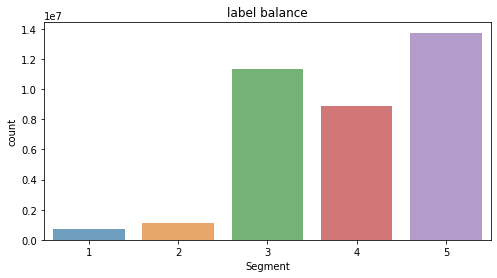

validation
5    3437502
3    2837411
4    2228416
2     283249
1     184326
Name: Segment, dtype: int64


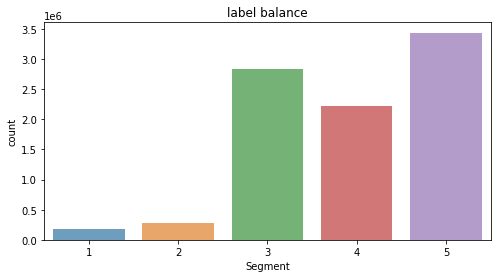

In [20]:
for d, name in zip([train, valid], ['train', 'validation']):
    print(name)
    eda_functions.show_label_balance(d, label='Segment')

In [21]:
del train
del valid

# Обучение моделей

In [22]:
target_names = [col for col in y_train.columns]
category_cols = X_train.columns
print(target_names)
print(category_cols)

['Segment_1', 'Segment_2', 'Segment_3', 'Segment_4', 'Segment_5']
Index(['gamecategory', 'subgamecategory', 'bundle', 'oblast', 'city', 'os',
       'osv', 'loc_weekday_tag', 'loc_is_weekend_tag',
       'loc_is_academic_year_tag', 'loc_time_of_day_tag'],
      dtype='object')


In [23]:
pars = {}
models = {}
eval_metric='auc'
TRAIN_FRAC = 1

In [24]:
pars['Segment_1'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.1,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 5,
}

pars['Segment_2'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.15,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 5,
}

pars['Segment_3'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.3,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 5,
}

pars['Segment_4'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.3,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 5,
}

pars['Segment_5'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.3,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 5,
}

In [25]:
for col in X_train.columns:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

In [26]:
for targ in target_names:
    models[targ] = train_model(pars[targ], X_train, y_train[targ], X_valid, y_valid[targ], eval_metric)

/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.684576
[2]	valid_0's auc: 0.692835
[3]	valid_0's auc: 0.693795
[4]	valid_0's auc: 0.696109
[5]	valid_0's auc: 0.697937
[6]	valid_0's auc: 0.700022
[7]	valid_0's auc: 0.701362
[8]	valid_0's auc: 0.701856
[9]	valid_0's auc: 0.703402
[10]	valid_0's auc: 0.704652
[11]	valid_0's auc: 0.706898
[12]	valid_0's auc: 0.709606
[13]	valid_0's auc: 0.708407
[14]	valid_0's auc: 0.713147
[15]	valid_0's auc: 0.711784
[16]	valid_0's auc: 0.712148
[17]	valid_0's auc: 0.716335
[18]	valid_0's auc: 0.715328
[19]	valid_0's auc: 0.717077
[20]	valid_0's auc: 0.717433
[21]	valid_0's auc: 0.717433
[22]	valid_0's auc: 0.719569
[23]	valid_0's auc: 0.718908
[24]	valid_0's auc: 0.718159
[25]	valid_0's auc: 0.721111
[26]	valid_0's auc: 0.720982
[27]	valid_0's auc: 0.720879
[28]	valid_0's auc: 0.721888
[29]	valid_0's auc: 0.722315
[30]	valid_0's auc: 0.724791
[31]	valid_0's auc: 0.724245
[32]	valid_0's auc: 0.724761
[33]	valid_0's auc: 0.723428
[34]	valid_0's auc: 0.723608
[35]	valid_0's auc: 0.7

/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.920224
[2]	valid_0's auc: 0.922343
[3]	valid_0's auc: 0.924439
[4]	valid_0's auc: 0.92543
[5]	valid_0's auc: 0.924707
[6]	valid_0's auc: 0.924906
[7]	valid_0's auc: 0.926332
[8]	valid_0's auc: 0.926569
[9]	valid_0's auc: 0.927314
[10]	valid_0's auc: 0.927555
[11]	valid_0's auc: 0.927995
[12]	valid_0's auc: 0.928602
[13]	valid_0's auc: 0.928668
[14]	valid_0's auc: 0.928739
[15]	valid_0's auc: 0.929182
[16]	valid_0's auc: 0.929216
[17]	valid_0's auc: 0.929486
[18]	valid_0's auc: 0.929581
[19]	valid_0's auc: 0.930099
[20]	valid_0's auc: 0.930457
[21]	valid_0's auc: 0.931009
[22]	valid_0's auc: 0.931222
[23]	valid_0's auc: 0.931388
[24]	valid_0's auc: 0.931385
[25]	valid_0's auc: 0.931888
[26]	valid_0's auc: 0.93204
[27]	valid_0's auc: 0.932159
[28]	valid_0's auc: 0.93227
[29]	valid_0's auc: 0.932254
[30]	valid_0's auc: 0.932311
[31]	valid_0's auc: 0.932415
[32]	valid_0's auc: 0.932428
[33]	valid_0's auc: 0.932418
[34]	valid_0's auc: 0.932599
[35]	valid_0's auc: 0.9327

/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.72786
[2]	valid_0's auc: 0.737876
[3]	valid_0's auc: 0.740791
[4]	valid_0's auc: 0.745517
[5]	valid_0's auc: 0.747943
[6]	valid_0's auc: 0.750445
[7]	valid_0's auc: 0.75305
[8]	valid_0's auc: 0.754283
[9]	valid_0's auc: 0.755494
[10]	valid_0's auc: 0.756862
[11]	valid_0's auc: 0.758721
[12]	valid_0's auc: 0.75924
[13]	valid_0's auc: 0.759983
[14]	valid_0's auc: 0.760418
[15]	valid_0's auc: 0.762651
[16]	valid_0's auc: 0.762858
[17]	valid_0's auc: 0.763353
[18]	valid_0's auc: 0.763859
[19]	valid_0's auc: 0.764102
[20]	valid_0's auc: 0.764935
[21]	valid_0's auc: 0.76551
[22]	valid_0's auc: 0.76567
[23]	valid_0's auc: 0.765956
[24]	valid_0's auc: 0.766824
[25]	valid_0's auc: 0.767018
[26]	valid_0's auc: 0.76804
[27]	valid_0's auc: 0.768096
[28]	valid_0's auc: 0.768298
[29]	valid_0's auc: 0.768754
[30]	valid_0's auc: 0.76893
[31]	valid_0's auc: 0.769446
[32]	valid_0's auc: 0.769543
[33]	valid_0's auc: 0.769602
[34]	valid_0's auc: 0.769656
[35]	valid_0's auc: 0.769851
[

/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.729342
[2]	valid_0's auc: 0.733652
[3]	valid_0's auc: 0.74073
[4]	valid_0's auc: 0.74325
[5]	valid_0's auc: 0.748721
[6]	valid_0's auc: 0.751915
[7]	valid_0's auc: 0.761812
[8]	valid_0's auc: 0.764546
[9]	valid_0's auc: 0.76848
[10]	valid_0's auc: 0.771282
[11]	valid_0's auc: 0.772495
[12]	valid_0's auc: 0.775729
[13]	valid_0's auc: 0.777847
[14]	valid_0's auc: 0.780037
[15]	valid_0's auc: 0.78042
[16]	valid_0's auc: 0.780991
[17]	valid_0's auc: 0.782569
[18]	valid_0's auc: 0.782994
[19]	valid_0's auc: 0.783084
[20]	valid_0's auc: 0.784095
[21]	valid_0's auc: 0.78486
[22]	valid_0's auc: 0.785773
[23]	valid_0's auc: 0.786433
[24]	valid_0's auc: 0.786978
[25]	valid_0's auc: 0.787469
[26]	valid_0's auc: 0.788745
[27]	valid_0's auc: 0.789581
[28]	valid_0's auc: 0.790113
[29]	valid_0's auc: 0.790072
[30]	valid_0's auc: 0.790759
[31]	valid_0's auc: 0.790848
[32]	valid_0's auc: 0.790876
[33]	valid_0's auc: 0.791511
[34]	valid_0's auc: 0.791911
[35]	valid_0's auc: 0.79209


/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.7672
[2]	valid_0's auc: 0.775812
[3]	valid_0's auc: 0.781284
[4]	valid_0's auc: 0.783779
[5]	valid_0's auc: 0.78803
[6]	valid_0's auc: 0.789481
[7]	valid_0's auc: 0.791131
[8]	valid_0's auc: 0.795997
[9]	valid_0's auc: 0.79906
[10]	valid_0's auc: 0.80027
[11]	valid_0's auc: 0.800718
[12]	valid_0's auc: 0.804297
[13]	valid_0's auc: 0.805355
[14]	valid_0's auc: 0.805963
[15]	valid_0's auc: 0.806903
[16]	valid_0's auc: 0.806986
[17]	valid_0's auc: 0.807991
[18]	valid_0's auc: 0.808237
[19]	valid_0's auc: 0.808855
[20]	valid_0's auc: 0.810049
[21]	valid_0's auc: 0.810444
[22]	valid_0's auc: 0.810692
[23]	valid_0's auc: 0.811912
[24]	valid_0's auc: 0.812361
[25]	valid_0's auc: 0.812591
[26]	valid_0's auc: 0.812935
[27]	valid_0's auc: 0.813276
[28]	valid_0's auc: 0.813789
[29]	valid_0's auc: 0.81391
[30]	valid_0's auc: 0.813903
[31]	valid_0's auc: 0.813884
[32]	valid_0's auc: 0.81422
[33]	valid_0's auc: 0.814306
[34]	valid_0's auc: 0.814421
[35]	valid_0's auc: 0.814669
[

model
Train roc auc 0.771363953903588
Validation roc auc 0.7247912451971193
              precision    recall  f1-score   support

           0       0.99      0.51      0.68   8786578
           1       0.03      0.79      0.06    184326

    accuracy                           0.52   8970904
   macro avg       0.51      0.65      0.37   8970904
weighted avg       0.97      0.52      0.66   8970904



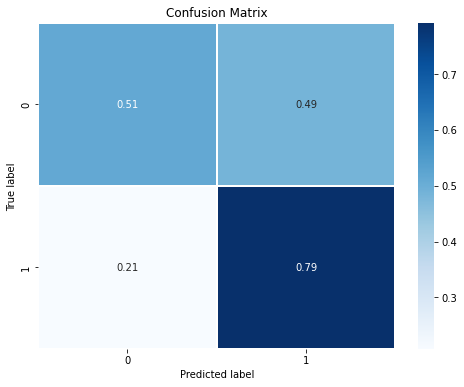

model
Train roc auc 0.9337793714543412
Validation roc auc 0.9328993601133845
              precision    recall  f1-score   support

           0       1.00      0.74      0.85   8687655
           1       0.11      0.97      0.20    283249

    accuracy                           0.75   8970904
   macro avg       0.55      0.86      0.52   8970904
weighted avg       0.97      0.75      0.83   8970904



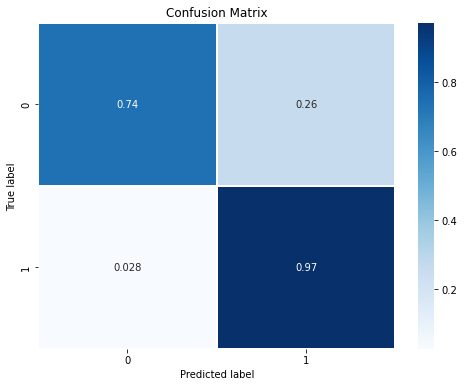

model
Train roc auc 0.7602826015985287
Validation roc auc 0.7782538134101878
              precision    recall  f1-score   support

           0       0.82      0.74      0.78   6133493
           1       0.54      0.66      0.60   2837411

    accuracy                           0.72   8970904
   macro avg       0.68      0.70      0.69   8970904
weighted avg       0.74      0.72      0.72   8970904



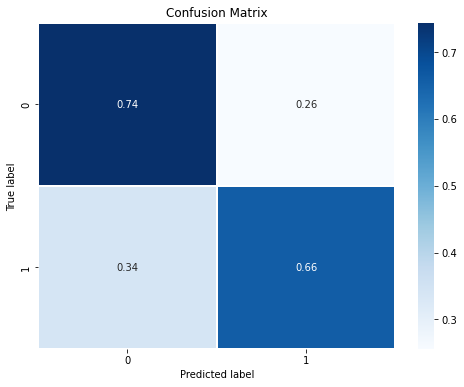

model
Train roc auc 0.7893876849556934
Validation roc auc 0.7973590077006786
              precision    recall  f1-score   support

           0       0.91      0.60      0.72   6742488
           1       0.40      0.82      0.54   2228416

    accuracy                           0.65   8970904
   macro avg       0.65      0.71      0.63   8970904
weighted avg       0.78      0.65      0.67   8970904



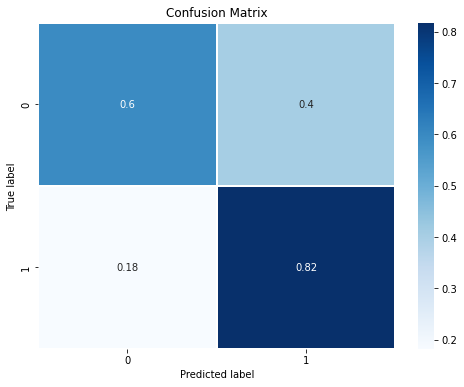

model
Train roc auc 0.8143489207009564
Validation roc auc 0.8205981807058765
              precision    recall  f1-score   support

           0       0.83      0.70      0.76   5533402
           1       0.61      0.77      0.68   3437502

    accuracy                           0.73   8970904
   macro avg       0.72      0.74      0.72   8970904
weighted avg       0.75      0.73      0.73   8970904



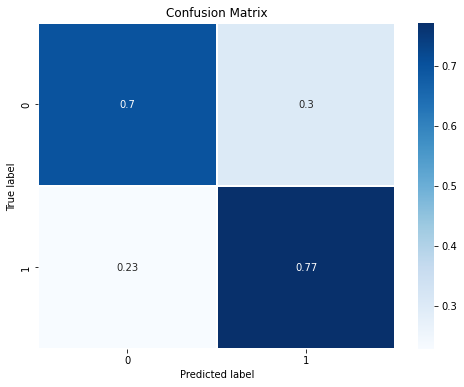

In [27]:
for targ in target_names:
    validate_model(models[targ], X_train, y_train[targ], X_valid, y_valid[targ])

# Сохраняем модели

In [36]:
version = 'v1.0'
for targ in target_names:
    model_name = f'lgbm_segment_{targ}_{version}.pkl'
    joblib.dump(models[targ], os.path.join(LGBM_MODELS_FOLDER, model_name))

# Верифицируем, что всё сохранилось хорошо и модели работают

In [39]:
loaded_models = {}
version = 'v1.0'
for targ in target_names:
    model_name = f'lgbm_segment_{targ}_{version}.pkl'
    loaded_models[targ] = joblib.load(os.path.join(LGBM_MODELS_FOLDER, model_name))

model
Train roc auc 0.771363953903588
Validation roc auc 0.7247912451971193
              precision    recall  f1-score   support

           0       0.99      0.51      0.68   8786578
           1       0.03      0.79      0.06    184326

    accuracy                           0.52   8970904
   macro avg       0.51      0.65      0.37   8970904
weighted avg       0.97      0.52      0.66   8970904



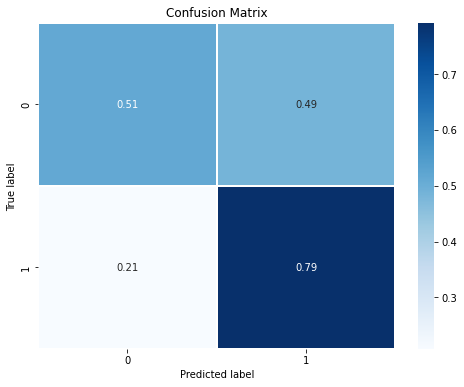

model
Train roc auc 0.9337793714543412
Validation roc auc 0.9328993601133845
              precision    recall  f1-score   support

           0       1.00      0.74      0.85   8687655
           1       0.11      0.97      0.20    283249

    accuracy                           0.75   8970904
   macro avg       0.55      0.86      0.52   8970904
weighted avg       0.97      0.75      0.83   8970904



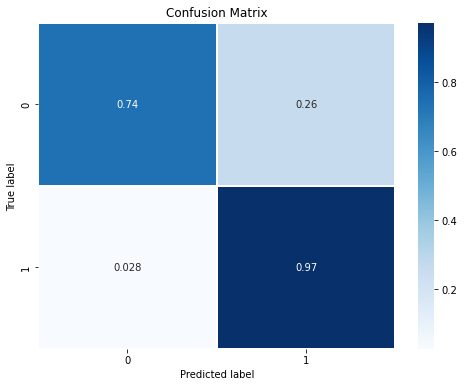

model
Train roc auc 0.7602826015985287
Validation roc auc 0.7782538134101878
              precision    recall  f1-score   support

           0       0.82      0.74      0.78   6133493
           1       0.54      0.66      0.60   2837411

    accuracy                           0.72   8970904
   macro avg       0.68      0.70      0.69   8970904
weighted avg       0.74      0.72      0.72   8970904



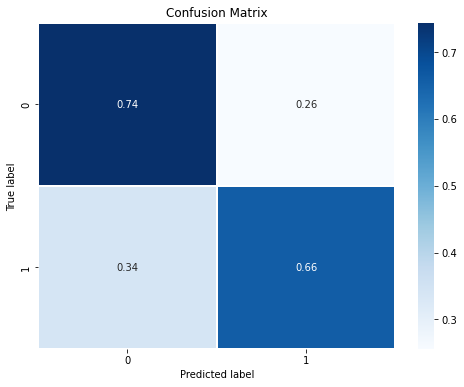

model
Train roc auc 0.7893876849556934
Validation roc auc 0.7973590077006786
              precision    recall  f1-score   support

           0       0.91      0.60      0.72   6742488
           1       0.40      0.82      0.54   2228416

    accuracy                           0.65   8970904
   macro avg       0.65      0.71      0.63   8970904
weighted avg       0.78      0.65      0.67   8970904



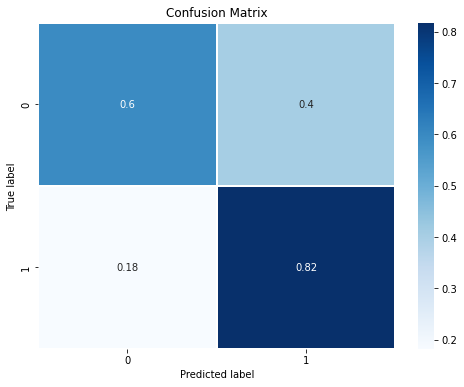

model
Train roc auc 0.8143489207009564
Validation roc auc 0.8205981807058765
              precision    recall  f1-score   support

           0       0.83      0.70      0.76   5533402
           1       0.61      0.77      0.68   3437502

    accuracy                           0.73   8970904
   macro avg       0.72      0.74      0.72   8970904
weighted avg       0.75      0.73      0.73   8970904



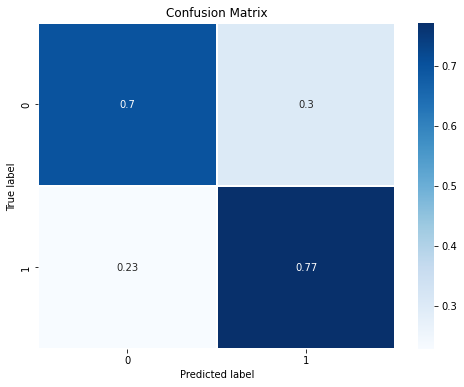

In [38]:
for targ in target_names:
    validate_model(loaded_models[targ], X_train, y_train[targ], X_valid, y_valid[targ])

# Предикт теста

## Подготовка данных

In [26]:
with open(os.path.join(MODES_FOLDER, 'mode_subgamecategory.pkl'), mode='rb') as file:
    mode_sub = pickle.load(file)
with open(os.path.join(MODES_FOLDER, 'mode_gamecategory.pkl'), mode='rb') as file:
    mode_game = pickle.load(file)

In [32]:
%autoreload 2
test_raw_preprocessed['subgamecategory'] = feature_preprocess.impute_column_test(test_raw_preprocessed, 'subgamecategory', mode_sub)
test_raw_preprocessed['gamecategory'] = feature_preprocess.impute_column_test(test_raw_preprocessed, 'gamecategory', mode_game)

In [51]:
test_raw_preprocessed[test_raw_preprocessed['subgamecategory'] != test_raw['subgamecategory'].str.upper()]

,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
1,NaN,NaN,COM.CHOCOCHOCOSTD.RAPBATTLE,2021-08-03 17:13:17,MSK+2,ЯМАЛО-НЕНЕЦКИЙ АО,НОВЫЙ УРЕНГОЙ,ANDROID,1
2,GAMES,BOARD,1387897651,2021-09-17 15:54:00,MSK,МОСКВА,МОСКВА,IOS,144
3,GAMES,SIMULATION,COM.COOKING.FAMILY.DIARY.FEVER.FOOD.CITY.CRAZE...,2021-07-05 23:34:59,MSK,КРАСНОДАРСКИЙ КРАЙ,КРАСНОДАР,ANDROID,9
6,NaN,NaN,INSTASAVER.INSTAGRAM.VIDEO.DOWNLOADER.PHOTO,2021-08-04 15:04:57,MSK+1,УДМУРТИЯ,ИЖЕВСК,ANDROID,81
8,GAMES,PUZZLE,COM.OPENMYGAME.GAMES.ANDROID.JIGSAWPUZZLE,2021-07-06 06:29:36,MSK+3,НОВОСИБИРСКАЯ ОБЛАСТЬ,НОВОСИБИРСК,ANDROID,1
...,...,...,...,...,...,...,...,...,...
11213623,GAMES,WORD,COM.FUGO.WOW,2021-07-05 08:16:10,MSK,МОСКВА,МОСКВА,ANDROID,1
11213624,GAMES,CASUAL,COM.PHONEMASTER.JEWELHUNTER,2021-08-04 05:55:26,MSK,САНКТ-ПЕТЕРБУРГ,САНКТ-ПЕТЕРБУРГ,ANDROID,81
11213625,GAMES,ARCADE,COM.LINKDESKS.JEWELLEGEND,2021-09-17 21:45:02,MSK,СТАВРОПОЛЬЕ,ПЯТИГОРСК,ANDROID,1
11213627,NaN,NaN,COM.ONEBUTTON.MRSUPER,2021-07-05 16:02:47,MSK+2,БАШКОРТОСТАН,БЕЛОРЕЦК,ANDROID,601


In [60]:
mode_sub

,bundle,subgamecategory_imputed
0,1000556973,NONE
1,1000773093,SPORTS
2,1000876192,CARD
3,1001044474,NONE
4,1001164812,RACING
...,...,...
85785,ZUKO.STICKERS.WHATSAPP,NaN
85786,ZUMAMARBLESHOOTER.MATCH3MARBLEDROP,NaN
85787,ZUMBALL.BLAST.CASUAL.MARBLE.GAME,CASUAL
85788,ZUPER.GAMESCLOUD,NaN


In [61]:
test_imputing = test_raw_preprocessed.copy()
test_imputing = test_imputing.reset_index()
column = 'subgamecategory'
test_imputing = test_imputing[['index', column, 'bundle']].merge(mode_sub, on='bundle', how='left').sort_values('index').reset_index(drop=True)

result = test_imputing[column].combine_first(test_imputing[f"{column}_imputed"])

In [80]:
test_raw

,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
0,Applications,Shopping,com.allgoritm.youla,2021-09-19 17:31:33,MSK+2,Свердловская область,Екатеринбург,android,10.0
1,NaN,NaN,com.ChocochocoStd.RapBattle,2021-08-03 17:13:17,MSK+2,Ямало-Ненецкий АО,Новый Уренгой,android,10.0
2,NaN,NaN,1387897651,2021-09-17 15:54:00,MSK,Москва,Москва,ios,14.4.0
3,NaN,NaN,com.cooking.family.diary.fever.food.city.craze...,2021-07-05 23:34:59,MSK,Краснодарский край,Краснодар,android,9.0.0
4,Applications,Health & Fitness,com.pedometer.stepcounter.tracker,2021-07-08 15:15:21,MSK,Татарстан,Набережные Челны,android,10.0
...,...,...,...,...,...,...,...,...,...
11213624,NaN,NaN,com.phonemaster.jewelhunter,2021-08-04 05:55:26,MSK,Санкт-Петербург,Санкт-Петербург,android,8.1.0
11213625,NaN,NaN,com.linkdesks.jewellegend,2021-09-17 21:45:02,MSK,Ставрополье,Пятигорск,android,10
11213626,Applications,Health & Fitness,com.pedometer.stepcounter.tracker,2021-07-08 10:24:31,MSK+6,Забайкальский Край,Чита,android,11.0
11213627,NaN,NaN,com.onebutton.mrsuper,2021-07-05 16:02:47,MSK+2,Башкортостан,Белорецк,android,6.0.1


In [78]:
test_raw_preprocessed

,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
0,APPLICATIONS,SHOPPING,COM.ALLGORITM.YOULA,2021-09-19 17:31:33,MSK+2,СВЕРДЛОВСКАЯ ОБЛАСТЬ,ЕКАТЕРИНБУРГ,ANDROID,1
1,NaN,NaN,COM.CHOCOCHOCOSTD.RAPBATTLE,2021-08-03 17:13:17,MSK+2,ЯМАЛО-НЕНЕЦКИЙ АО,НОВЫЙ УРЕНГОЙ,ANDROID,1
2,GAMES,BOARD,1387897651,2021-09-17 15:54:00,MSK,МОСКВА,МОСКВА,IOS,144
3,GAMES,SIMULATION,COM.COOKING.FAMILY.DIARY.FEVER.FOOD.CITY.CRAZE...,2021-07-05 23:34:59,MSK,КРАСНОДАРСКИЙ КРАЙ,КРАСНОДАР,ANDROID,9
4,APPLICATIONS,HEALTH & FITNESS,COM.PEDOMETER.STEPCOUNTER.TRACKER,2021-07-08 15:15:21,MSK,ТАТАРСТАН,НАБЕРЕЖНЫЕ ЧЕЛНЫ,ANDROID,1
...,...,...,...,...,...,...,...,...,...
11213624,GAMES,CASUAL,COM.PHONEMASTER.JEWELHUNTER,2021-08-04 05:55:26,MSK,САНКТ-ПЕТЕРБУРГ,САНКТ-ПЕТЕРБУРГ,ANDROID,81
11213625,GAMES,ARCADE,COM.LINKDESKS.JEWELLEGEND,2021-09-17 21:45:02,MSK,СТАВРОПОЛЬЕ,ПЯТИГОРСК,ANDROID,1
11213626,APPLICATIONS,HEALTH & FITNESS,COM.PEDOMETER.STEPCOUNTER.TRACKER,2021-07-08 10:24:31,MSK+6,ЗАБАЙКАЛЬСКИЙ КРАЙ,ЧИТА,ANDROID,11
11213627,NaN,NaN,COM.ONEBUTTON.MRSUPER,2021-07-05 16:02:47,MSK+2,БАШКОРТОСТАН,БЕЛОРЕЦК,ANDROID,601


In [91]:
(test_raw['subgamecategory'].str.upper() != test_raw_preprocessed['subgamecategory']).sum() / test_raw.shape[0]

0.37834451273535086

In [90]:
test_raw['subgamecategory'].isna().sum() / test_raw.shape[0], test_raw_preprocessed['subgamecategory'].isna().sum() / test_raw.shape[0]

(0.37834451273535086, 0.06198261062498144)

In [92]:
mode_sub[mode_sub['bundle'] == 'COM.PIXONIC.WWR']

,bundle,subgamecategory_imputed
57442,COM.PIXONIC.WWR,ACTION


In [94]:
test_raw[test_raw['bundle'].str.upper() == 'COM.PIXONIC.WWR']

,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
114,NaN,NaN,com.pixonic.wwr,2021-08-05 05:18:19,MSK+2,Свердловская область,Екатеринбург,android,10.0.0
197,NaN,NaN,com.pixonic.wwr,2021-09-18 03:50:02,MSK+4,Кемеровская область,Кемерово,android,8.0.0
1384,Games,Action,com.pixonic.wwr,2021-08-08 10:33:24,MSK+2,Свердловская область,Екатеринбург,android,10.0
1932,NaN,NaN,com.pixonic.wwr,2021-08-06 13:46:10,MSK,Москва,Москва,android,11.0.0
1988,NaN,NaN,com.pixonic.wwr,2021-09-18 07:01:48,MSK,Москва,Москва,android,11.0.0
...,...,...,...,...,...,...,...,...,...
11212349,NaN,NaN,com.pixonic.wwr,2021-09-15 12:00:04,MSK,Москва,Москва,android,8.1.0
11212372,NaN,NaN,com.pixonic.wwr,2021-08-02 18:19:32,MSK,Краснодарский край,NaN,android,10.0.0
11213068,NaN,NaN,com.pixonic.wwr,2021-08-04 12:22:29,MSK,Краснодарский край,Краснодар,android,9.0.0
11213446,NaN,NaN,com.pixonic.wwr,2021-09-17 13:19:27,MSK,Нижегородская область,NaN,android,9.0.0


In [95]:
mode_sub[mode_sub['bundle'] == '1387897651']

,bundle,subgamecategory_imputed
3449,1387897651,BOARD


In [96]:
test_raw[test_raw['bundle'].str.upper() == '1387897651']

,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
2,NaN,NaN,1387897651,2021-09-17 15:54:00,MSK,Москва,Москва,ios,14.4.0
5993,NaN,NaN,1387897651,2021-08-05 07:29:59,MSK,Московская область,Звенигород,ios,14.6.0
14744,Games,Board,1387897651,2021-08-05 18:27:13,MSK,Санкт-Петербург,Санкт-Петербург,ios,11.4.1
19606,Games,Board,1387897651,2021-09-19 14:42:46,MSK+7,Хабаровский край,Хабаровск,ios,14.7.1
23232,NaN,NaN,1387897651,2021-09-19 20:20:42,MSK,Татарстан,Казань,ios,14.2.0
...,...,...,...,...,...,...,...,...,...
11187140,Games,Board,1387897651,2021-08-08 17:30:14,MSK,Татарстан,Казань,ios,14.7.1
11206898,Games,Board,1387897651,2021-07-08 18:55:00,MSK,Краснодарский край,Краснодар,ios,12.4.5
11210134,NaN,NaN,1387897651,2021-08-05 10:01:03,MSK,Калужская область,Калуга,ios,12.5.4
11210385,NaN,NaN,1387897651,2021-09-19 18:36:07,MSK,Москва,Москва,ios,11.4.0


In [35]:
test_raw_time_ftrs = \
feature_preprocess.make_features_from_time(
    test_raw_preprocessed,
    dt_target='loc',
    datetime_col_msk='created',
    shift_col = 'shift',
    fill_shift_na=False,
    shift_filler='MSK',
    dt_format = '%Y-%m-%d %H:%M:%S'
    )

print('make_features_from_time done')

test_raw_time_ftrs = feature_preprocess.get_tags_from_time_features(
    test_raw_time_ftrs, 
    tags_cols=TIME_TAGS_COLS, 
    tags_dict=None)

print('get_tags_from_time_features done')

test_raw_all_ftrs = test_raw.join(test_raw_time_ftrs)
test_raw_all_ftrs.drop(columns=['created', 'shift'], inplace=True)

print('dataset prepared successfully')

make_features_from_time done
get_tags_from_time_features done
dataset prepared successfully


In [41]:
for col in test_raw_all_ftrs.columns:
    test_raw_all_ftrs[col] = test_raw_all_ftrs[col].astype('category')

In [42]:
test_predic_proba = {}
target_names = ['Segment_1', 'Segment_2', 'Segment_3', 'Segment_4', 'Segment_5']
for targ in target_names:
    test_predic_proba[targ] = loaded_models[targ].predict_proba(test_raw_all_ftrs).T[1]

In [43]:
test_predictions = pd.DataFrame(dtype=np.float64)
for targ in target_names:
    test_predictions[f'Segment_{targ}_proba'] = test_predic_proba[targ]

In [44]:
display(test_predictions)

,Segment_Segment_1_proba,Segment_Segment_2_proba,Segment_Segment_3_proba,Segment_Segment_4_proba,Segment_Segment_5_proba
0,0.320365,0.111646,0.519805,0.074546,0.826003
1,0.375232,0.001174,0.807213,0.632546,0.021666
2,0.320365,0.735692,0.455712,0.071948,0.684746
3,0.375232,0.001174,0.800622,0.559823,0.032932
4,0.373774,0.001174,0.829350,0.606539,0.034942
...,...,...,...,...,...
11213624,0.337059,0.001174,0.581689,0.295732,0.749535
11213625,0.324137,0.112543,0.051959,0.146313,0.903331
11213626,0.373774,0.001174,0.829350,0.606539,0.034942
11213627,0.375232,0.001174,0.735200,0.552858,0.065870


In [47]:
postfix = '_lgbm_v10'
test_predictions.to_csv(os.path.join(OUTPUT_FOLDER, f'test_predictions{postfix}.csv'), index=False)